In [1]:
import pandas as pd
from pandas import Series,DataFrame
%pylab inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import seaborn as sns



Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = 'Gun Violence Data.csv'
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df_raw = pd.read_csv(filename,parse_dates=['date'], date_parser=dateparse)

In [3]:
df_raw.shape
df_raw.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [4]:
## Dropping the irrelevant columns

df_raw = df_raw.drop(columns=['incident_url','source_url','incident_url_fields_missing','participant_name','sources','address','notes'])
print(df_raw.shape)

(239677, 22)


In [5]:
df_raw.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'n_killed',
       'n_injured', 'congressional_district', 'gun_stolen', 'gun_type',
       'incident_characteristics', 'latitude', 'location_description',
       'longitude', 'n_guns_involved', 'participant_age',
       'participant_age_group', 'participant_gender',
       'participant_relationship', 'participant_status', 'participant_type',
       'state_house_district', 'state_senate_district'],
      dtype='object')

In [6]:
## Cleaning the agegroups
## https://www.kaggle.com/bhaveshthaker/gvd-data-prep-feature-eng-exploratory-analysis

df_raw['participant_age_group'] = df_raw['participant_age_group'].fillna("0:Unknown")

def getcleanages(s):
    agegroups = []
    people = s.split('||')
    for i in people:
        x = i.split('::')
        if len(x) > 1:
            agegroups.append(x[1])
    return agegroups


df_raw_ages_cleaned = df_raw['participant_age_group'].map(getcleanages)
df_raw['children'] = df_raw_ages_cleaned.map(lambda x: x.count("Child 0-11"))
df_raw['teen'] = df_raw_ages_cleaned.map(lambda x: x.count("Teen 12-17"))
df_raw['adults'] = df_raw_ages_cleaned.map(lambda x: x.count("Adult 18+"))
df_raw.head(5)


,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,...,participant_age_group,participant_gender,participant_relationship,participant_status,participant_type,state_house_district,state_senate_district,children,teen,adults
0,461105,2013-01-01,Pennsylvania,Mckeesport,0,4,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN,0,0,5
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,62.0,35.0,0,0,4
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,56.0,13.0,0,0,5
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,40.0,28.0,0,0,4
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,62.0,27.0,0,1,3


In [7]:
## Cleaning the gender columns

df_raw['participant_gender'] = df_raw['participant_gender'].fillna("0:Unknown")

def getcleangender(s):
    gendergroups = []
    people = s.split('||')
    for i in people:
        x = i.split('::')
        if len(x) > 1:
            gendergroups.append(x[1])
    return gendergroups


df_raw_gender_cleaned = df_raw['participant_gender'].map(getcleangender)
df_raw['Male'] = df_raw_gender_cleaned.map(lambda x: x.count("Male"))
df_raw['Female'] = df_raw_gender_cleaned.map(lambda x: x.count("Female"))

In [8]:
## Cleaning the gender columns

df_raw['incident_characteristics'] = df_raw['incident_characteristics'].fillna("Uknown")

def getcleanincidents(s):
    incidents = []
    x = s.split('||')
    for i in x:
            incidents.append(i)
    return incidents


def isaccidental(l):
        if ('Accidental Shooting' in l or 'Accidental Shooting - Death' in l or 'Accidental Shooting - Injury' in l or 'Accidental Shooting at a Business' in l or 'Accidental/Negligent Discharge' in l):
            return 1
        else:
            return 0

def isrobbery(l):
        if ('Armed robbery with injury/death and/or evidence of DGU found' in l or 'Criminal act with stolen gun' in l or 'Car-jacking' in l):
            return 1
        else:
            return 0

def attempted(l):
        if ('Attempted Murder/Suicide (one variable unsuccessful)' in l):
            return 1
        else:
            return 0

def barorclub(l):
        if ('Bar/club incident - in or around establishment' in l):
            return 1
        else:
            return 0

def children(l):
        if ('Child injured (not child shooter)' in l or 'Child injured by child' in l or 'Child injured self' in l or 'Child Involved Incident' in l or 'Child killed (not child shooter)' in l or 'Child killed by child' in l or 'Child killed self' in l or 'Child picked up & fired gun' in l):
            return 1
        else:
            return 0
        
def defensive(l):
        if ('Defensive Use' in l or 'Defensive Use - Crime occurs, victim shoots subject/suspect/perpetrator' in l or 'Defensive Use - Good Samaritan/Third Party' in l or 'Defensive use - No shots fired' in l or 'Defensive Use - Shots fired, no injury/death' in l or 'Defensive Use - Stand Your Ground/Castle Doctrine established' in l or 'Defensive Use - Victim stops crime' in l or 'Defensive Use - WITHOUT a gun' in l):
            return 1
        else:
            return 0

def druggang(l):
        if ('Drug involvement' in l or 'Gang involvement' in l):
            return 1
        else:
            return 0
        
def school(l):
        if ('School Incident' in l or 'School Shooting - elementary/secondary school' in l or 'School Shooting - university/college' in l or 'Gun at school, no death/injury - elementary/secondary school' in l or 'Gun at school, no death/injury - university/college' in l):
            return 1
        else:
            return 0

def home(l):
        if ('Home Invasion' in l or 'Home Invasion - No death or injury' in l or 'Home Invasion - Resident injured' in l or 'Home Invasion - Resident killed' in l or 'Home Invasion - subject/suspect/perpetrator injured' in l or 'Home Invasion - subject/suspect/perpetrator killed' in l):
            return 1
        else:
            return 0

def massshooting(l):
        if ('Mass Murder (4+ deceased victims excluding the subject/suspect/perpetrator , one location)' in l or 'Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)' in l):
            return 1
        else:
            return 0
        
def murder(l):
        if ('Murder/Suicide' in l):
            return 1
        else:
            return 0

def officerinvolved(l):
        if ('Officer Involved Incident' in l or 'Officer Involved Incident - Weapon involved but no shots fired' in l or 'Officer Involved Shooting - Accidental discharge - no injury required' in l or 'Officer Involved Shooting - Bystander killed' in l or 'Officer Involved Shooting - Bystander shot' in l or 'Officer Involved Shooting - Officer killed' in l or 'Officer Involved Shooting - Officer shot' in l or 'Officer Involved Shooting - Shots fired, no injury' in l or 'Officer Involved Shooting - subject/suspect/perpetrator killed' in l or 'Officer Involved Shooting - subject/suspect/perpetrator shot' in l or 'Officer Involved Shooting - subject/suspect/perpetrator suicide at standoff' in l or 'Officer Involved Shooting - subject/suspect/perpetrator suicide by cop' in l or 'Officer Involved Shooting - subject/suspect/perpetrator surrender at standoff' in l or 'Officer Involved Shooting - subject/suspect/perpetrator unarmed' in l):
            return 1
        else:
            return 0

        
df_raw_incidents_cleaned = df_raw['incident_characteristics'].map(getcleanincidents)
df_raw['Accidental Shooting'] = df_raw_incidents_cleaned.map(isaccidental)
df_raw['Attempted Murder/Suicide'] = df_raw_incidents_cleaned.map(attempted)
df_raw['Armed Robbery'] = df_raw_incidents_cleaned.map(isrobbery)
df_raw['Bar/Club Incident'] = df_raw_incidents_cleaned.map(barorclub)
df_raw['Children Injured/Killed'] = df_raw_incidents_cleaned.map(children)
df_raw['Defensive Use'] = df_raw_incidents_cleaned.map(defensive)
df_raw['Drug/Gang Related'] = df_raw_incidents_cleaned.map(druggang)
df_raw['Incident at School'] = df_raw_incidents_cleaned.map(school)
df_raw['Home Invastion'] = df_raw_incidents_cleaned.map(home)
df_raw['Mass Shooting'] = df_raw_incidents_cleaned.map(massshooting)
df_raw['Murder/Suicide'] = df_raw_incidents_cleaned.map(murder)
df_raw['OfficerInvolved'] = df_raw_incidents_cleaned.map(officerinvolved)


In [9]:
## Dropping additional irrelevant columns

df_raw = df_raw.drop(columns=['congressional_district','gun_stolen','gun_type','participant_age_group','participant_gender','participant_age','participant_relationship','participant_status','participant_type','state_house_district','state_senate_district','incident_characteristics'])
print(df_raw.shape)

#df_raw[['Accidental Shooting','Attempted Murder/Suicide','Armed Robbery','Bar/Club Incident','Children Injured/Killed','Defensive Use','Drug/Gang Related','Incident at School','Home Invastion','Mass Shooting','Murder/Suicide','OfficerInvolved']]

(239677, 27)


In [10]:
## Extracting Year, Month and Day of week

def dow(dt):
    return dt.day_name()

df_raw['Month'] = df_raw['date'].dt.strftime("%B")
df_raw['DayofWeek'] = df_raw['date'].map(dow)
df_raw['Year'] = df_raw['date'].dt.year


In [11]:
print(df_raw.shape)
print(df_raw.head(5))

(239677, 30)
   incident_id       date           state city_or_county  n_killed  n_injured  \
0       461105 2013-01-01    Pennsylvania     Mckeesport         0          4   
1       460726 2013-01-01      California      Hawthorne         1          3   
2       478855 2013-01-01            Ohio         Lorain         1          3   
3       478925 2013-01-05        Colorado         Aurora         4          0   
4       478959 2013-01-07  North Carolina     Greensboro         2          2   

   latitude location_description  longitude  n_guns_involved  ...  \
0   40.3467                  NaN   -79.8559              NaN  ...   
1   33.9090                  NaN  -118.3330              NaN  ...   
2   41.4455          Cotton Club   -82.1377              2.0  ...   
3   39.6518                  NaN  -104.8020              NaN  ...   
4   36.1140                  NaN   -79.9569              2.0  ...   

   Defensive Use  Drug/Gang Related  Incident at School  Home Invastion  \
0         

In [12]:
## Dropping 2013 data (?)

df_raw = df_raw.drop(df_raw[(df_raw['Year'] == 2013)].index)
print (df_raw.shape)

(239399, 30)


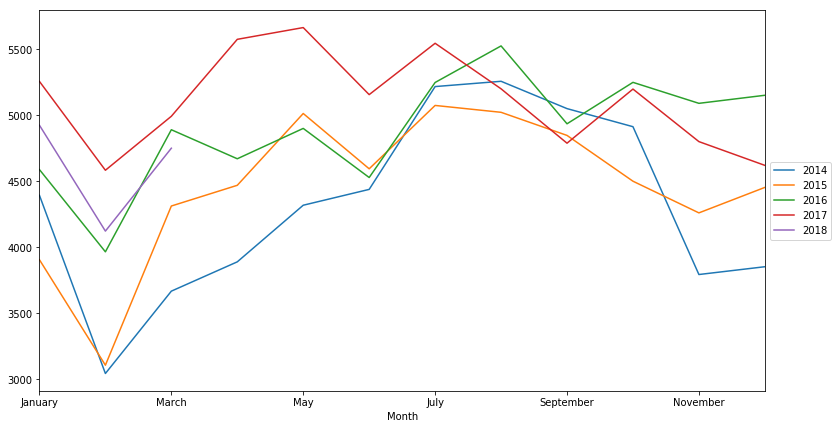

In [13]:
## Orders by Month

df_monthly_incidents = df_raw.groupby(['Month','Year'])[['state']].count()
df_monthly_incidents = pd.DataFrame(df_monthly_incidents.to_records())
month_order = ["January", "February", "March", "April", "May", "June", "July","August", "September", "October", "November", "December"]
#df_monthly_incidents = df_monthly_incidents.set_index("Month").loc[month_order]


fig = plt.figure(figsize=(13,7))
for year in range(2014,2019):
    df_temp = df_monthly_incidents[df_monthly_incidents['Year'] == year]
    df_temp.set_index("Month").loc[month_order]['state'].plot(label = year)

    
plt.legend(loc = 'center left',bbox_to_anchor = (1,0.5))
plt.show()



In [ ]:
## Orders by Month

df_monthly_incidents = df_raw.groupby(['Month','Year'])[['state']].count()
df_monthly_incidents = pd.DataFrame(df_monthly_incidents.to_records())
month_order = ["January", "February", "March", "April", "May", "June", "July","August", "September", "October", "November", "December"]
#df_monthly_incidents = df_monthly_incidents.set_index("Month").loc[month_order]


fig = plt.figure(figsize=(13,7))
for year in range(2014,2019):
    df_temp = df_monthly_incidents[df_monthly_incidents['Year'] == year]
    df_temp.set_index("Month").loc[month_order]['state'].plot(label = year)

    
plt.legend(loc = 'center left',bbox_to_anchor = (1,0.5))
plt.show()



In [14]:
df_monthly_incidents

,Month,Year,state
0,April,2014,3891
1,April,2015,4471
2,April,2016,4672
3,April,2017,5577
4,August,2014,5259
5,August,2015,5024
6,August,2016,5527
7,August,2017,5202
8,December,2014,3854
9,December,2015,4455


In [28]:
df_raw[df_raw['Year'] < 2018].groupby(['Month'])[['Year']].count()/4


,Year
Month,
April,4652.75
August,5253.00
December,4521.00
February,3676.25
January,4537.50
July,5273.00
June,4681.00
March,4467.25
May,4975.75


In [13]:
import csv
df_raw.to_csv('Cleaned_data.csv')